In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


C:\Users\Diego Merello\miniconda3\envs\project3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [36]:
df_train=pd.read_csv('Diamondssql.csv')
df_test=pd.read_csv('diamonds_test.csv')

In [37]:
df_train.columns

Index(['color', 'cut', 'clarity', 'price', 'city', 'depth', 'carat', 'table',
       'x', 'y', 'z'],
      dtype='object')

In [38]:
def missing_percentage (df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_values_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
    return missing_values_df

In [39]:
missing_percentage(df_train)

,column_name,percent_missing
color,color,0.0
cut,cut,0.0
clarity,clarity,0.0
price,price,0.0
city,city,0.0
depth,depth,0.0
carat,carat,0.0
table,table,0.0
x,x,0.0
y,y,0.0


In [40]:
df_train.describe()

,price,depth,carat,table,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,61.752841,0.797706,57.446133,5.729392,5.732819,3.537154
std,3992.416147,1.431725,0.475544,2.233535,1.124453,1.146650,0.697062
min,326.000000,43.000000,0.200000,43.000000,0.000000,0.000000,0.000000
25%,945.000000,61.000000,0.400000,56.000000,4.710000,4.720000,2.910000
50%,2397.000000,61.800000,0.700000,57.000000,5.690000,5.710000,3.520000
75%,5331.000000,62.500000,1.040000,59.000000,6.540000,6.540000,4.035000
max,18823.000000,79.000000,4.500000,95.000000,10.230000,58.900000,8.060000


In [41]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [43]:
remove_outlier(df_train, 'carat')

,color,cut,clarity,price,city,depth,carat,table,x,y,z
0,J,Premium,VS2,4268,Dubai,62.4,1.21,58.0,6.83,6.79,4.25
1,H,Very Good,VS2,505,Kimberly,63.0,0.32,57.0,4.35,4.38,2.75
2,G,Fair,VS1,2686,Las Vegas,65.5,0.71,55.0,5.62,5.53,3.65
3,D,Good,SI1,738,Kimberly,63.8,0.41,56.0,4.68,4.72,3.00
4,G,Ideal,SI1,4882,Dubai,60.5,1.02,59.0,6.55,6.51,3.95
...,...,...,...,...,...,...,...,...,...,...,...
40449,F,Ideal,VS1,3710,Kimberly,61.9,0.71,56.0,5.69,5.72,3.53
40450,G,Ideal,VS1,10070,Antwerp,62.7,1.34,57.0,7.10,7.04,4.43
40452,H,Ideal,SI1,5457,Kimberly,62.7,1.01,56.0,6.37,6.42,4.01
40453,J,Ideal,VS1,456,Kimberly,61.9,0.33,54.3,4.45,4.47,2.76


In [32]:
q_low = df_train["price"].quantile(0.01)
q_hi  = df_train["price"].quantile(0.99)

In [33]:
df_train = df_train[(df_train["price"] < q_hi) & (df_train["price"] > q_low)]
df_train

,color,cut,clarity,price,city,depth,carat,table,x,y,z
0,J,Premium,VS2,4268,Dubai,62.4,1.21,58.0,6.83,6.79,4.25
1,H,Very Good,VS2,505,Kimberly,63.0,0.32,57.0,4.35,4.38,2.75
2,G,Fair,VS1,2686,Las Vegas,65.5,0.71,55.0,5.62,5.53,3.65
3,D,Good,SI1,738,Kimberly,63.8,0.41,56.0,4.68,4.72,3.00
4,G,Ideal,SI1,4882,Dubai,60.5,1.02,59.0,6.55,6.51,3.95
...,...,...,...,...,...,...,...,...,...,...,...
40450,G,Ideal,VS1,10070,Antwerp,62.7,1.34,57.0,7.10,7.04,4.43
40451,F,Good,SI2,12615,Madrid,57.1,2.02,60.0,8.31,8.25,4.73
40452,H,Ideal,SI1,5457,Kimberly,62.7,1.01,56.0,6.37,6.42,4.01
40453,J,Ideal,VS1,456,Kimberly,61.9,0.33,54.3,4.45,4.47,2.76


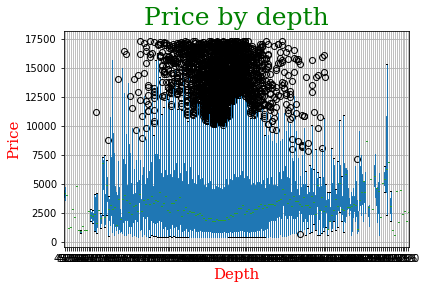

In [34]:
df_train.boxplot(column='price', by='depth')
font1 = {'family':'serif','color':'green','size':25}
font2 = {'family':'serif','color':'red','size':15}
plt.ylabel('Price',fontdict=font2)
plt.xlabel('Depth',fontdict=font2)
plt.suptitle('')
plt.title('Price by depth',fontdict=font1)
plt.show()

In [35]:
df_train

,color,cut,clarity,price,city,depth,carat,table,x,y,z
0,J,Premium,VS2,4268,Dubai,62.4,1.21,58.0,6.83,6.79,4.25
1,H,Very Good,VS2,505,Kimberly,63.0,0.32,57.0,4.35,4.38,2.75
2,G,Fair,VS1,2686,Las Vegas,65.5,0.71,55.0,5.62,5.53,3.65
3,D,Good,SI1,738,Kimberly,63.8,0.41,56.0,4.68,4.72,3.00
4,G,Ideal,SI1,4882,Dubai,60.5,1.02,59.0,6.55,6.51,3.95
...,...,...,...,...,...,...,...,...,...,...,...
40450,G,Ideal,VS1,10070,Antwerp,62.7,1.34,57.0,7.10,7.04,4.43
40451,F,Good,SI2,12615,Madrid,57.1,2.02,60.0,8.31,8.25,4.73
40452,H,Ideal,SI1,5457,Kimberly,62.7,1.01,56.0,6.37,6.42,4.01
40453,J,Ideal,VS1,456,Kimberly,61.9,0.33,54.3,4.45,4.47,2.76


In [11]:
df_test

,id,carat,cut,color,clarity,depth,table,x,y,z,city
0,0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,Amsterdam
13481,13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,New York City
13482,13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,Tel Aviv
13483,13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,Surat


In [12]:
target=['price']
cat_features=['cut', 'color', 'clarity', 'city']
num_features=['carat', 'depth', 'table', 'x', 'y', 'z']

In [13]:
for cat_feat in cat_features:
    df_train[cat_feat]=df_train[cat_feat].astype('category')
    df_test[cat_feat]=df_test[cat_feat].astype('category')

C:\Users\Diego Merello\AppData\Local\Temp\ipykernel_6612\4220047071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cat_feat]=df_train[cat_feat].astype('category')
C:\Users\Diego Merello\AppData\Local\Temp\ipykernel_6612\4220047071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cat_feat]=df_train[cat_feat].astype('category')
C:\Users\Diego Merello\AppData\Local\Temp\ipykernel_6612\4220047071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [14]:
cat_df=pd.get_dummies(df_train[cat_features])
num_df=df_train.loc[:, num_features]
train_df=pd.concat([cat_df,num_df], axis=1)

cat_df =pd.get_dummies(df_test[cat_features])
num_df=df_test.loc[:, num_features]
test_df= pd.concat([cat_df, num_df], axis=1)

features= list (cat_df.columns) + list(num_df.columns)

In [15]:
features

['cut_Fair',
 'cut_Good',
 'cut_Ideal',
 'cut_Premium',
 'cut_Very Good',
 'color_D',
 'color_E',
 'color_F',
 'color_G',
 'color_H',
 'color_I',
 'color_J',
 'clarity_I1',
 'clarity_IF',
 'clarity_SI1',
 'clarity_SI2',
 'clarity_VS1',
 'clarity_VS2',
 'clarity_VVS1',
 'clarity_VVS2',
 'city_Amsterdam',
 'city_Antwerp',
 'city_Dubai',
 'city_Kimberly',
 'city_Las Vegas',
 'city_London',
 'city_Luxembourg',
 'city_Madrid',
 'city_New York City',
 'city_Paris',
 'city_Surat',
 'city_Tel Aviv',
 'city_Zurich',
 'carat',
 'depth',
 'table',
 'x',
 'y',
 'z']

In [24]:
train_df

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,...,city_Paris,city_Surat,city_Tel Aviv,city_Zurich,carat,depth,table,x,y,z
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.21,62.4,58.0,6.83,6.79,4.25
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0.32,63.0,57.0,4.35,4.38,2.75
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0.71,65.5,55.0,5.62,5.53,3.65
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0.41,63.8,56.0,4.68,4.72,3.00
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1.02,60.5,59.0,6.55,6.51,3.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1.34,62.7,57.0,7.10,7.04,4.43
40451,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,2.02,57.1,60.0,8.31,8.25,4.73
40452,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1.01,62.7,56.0,6.37,6.42,4.01
40453,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0.33,61.9,54.3,4.45,4.47,2.76


In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(train_df.loc[:,features].values)
y = df_train['price']

In [17]:
X_train, X_validation, y_train, y_validation=train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
model = RandomForestRegressor()
#model.fit(X=X_train,y=y_train)
model.fit(X,y)


RandomForestRegressor()

In [2]:
#clf = LazyClassifier(predictions=True)
#models, predictions = clf.fit(X_train, X_validation, y_train, y_validation)

NameError: name 'LazyClassifier' is not defined

In [19]:
#Se hace el scalar al Test, sólo a los valores
X_test=scaler.transform(test_df.loc[:,features].values)

In [20]:
X_test

array([[-0.17698353, -0.31425389, -0.82144884, ...,  0.0905082 ,
         0.14812566,  0.20258012],
       [-0.17698353, -0.31425389,  1.21736126, ...,  0.99292704,
         1.04033526,  0.95207275],
       [-0.17698353, -0.31425389, -0.82144884, ...,  1.51250152,
         1.42398539,  1.52521416],
       ...,
       [-0.17698353, -0.31425389,  1.21736126, ...,  0.02670081,
        -0.01247207, -0.00316295],
       [-0.17698353, -0.31425389, -0.82144884, ...,  0.11785423,
         0.14812566, -0.12073042],
       [-0.17698353, -0.31425389,  1.21736126, ..., -0.93041008,
        -0.88683749, -0.87022305]])

In [21]:
#Realizo la predicción
Price_predict=model.predict(X_test).clip(0,30000) #es es con el data entero
#Price_predict=model.predict(X_validation).clip(0,30000)

In [22]:
rmse=mean_squared_error(y_validation, Price_predict)**0.5
rmse

ValueError: Found input variables with inconsistent numbers of samples: [7929, 13485]

In [23]:
X_test= scaler.transform(test_df.loc[:,features].values)
y_hat = model.predict(X_test).clip(0,30000) #esta es la predicción. es un array de numpy
submission = pd.DataFrame({'id': df_test['id'], 'price': y_hat}) #convertimos a dataframe y le damos forma
submission.to_csv('submission3.csv', index=False)

In [ ]:
mean_squared_error()